## Importing Dataset and Libraries

In [1]:
# importing important libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import metrics
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Importing the dataset
df = pd.read_csv("//Users//kaustubhgarg//Desktop//household_power_consumption.txt",delimiter = ';')
df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


## Data Cleaning and Preprocessing

In [5]:
# Getting an idea about the datatype
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Date                   object 
 1   Time                   object 
 2   Global_active_power    object 
 3   Global_reactive_power  object 
 4   Voltage                object 
 5   Global_intensity       object 
 6   Sub_metering_1         object 
 7   Sub_metering_2         object 
 8   Sub_metering_3         float64
dtypes: float64(1), object(8)
memory usage: 142.5+ MB


In [ ]:
'''
Conclusions: 
1. There are total 2075259 entries in the dataset.
2. The datatype of the columns is "object" which is incorrect.
'''

In [8]:
# Checking for duplicate rows
df.duplicated().sum()

0

In [ ]:
'''
Conclusions: 
zero indicates that there are no duplicate rows in the dataset
'''

In [11]:
# Combining date and time columns to datetime format
df['Datetime'] = pd.to_datetime(df[['Date', 'Time']].agg(' '.join, axis=1), format='%d/%m/%Y %H:%M:%S')

In [12]:
# converting the datatype of other columns to numeric datatypes
df['Global_active_power'] = pd.to_numeric(df['Global_active_power'],errors = 'coerce')
df['Global_reactive_power'] = pd.to_numeric(df['Global_reactive_power'],errors = 'coerce')
df['Voltage'] = pd.to_numeric(df['Voltage'],errors = 'coerce')
df['Global_intensity'] = pd.to_numeric(df['Global_intensity'],errors = 'coerce')
df['Sub_metering_1'] = pd.to_numeric(df['Sub_metering_1'],errors = 'coerce')
df['Sub_metering_2'] = pd.to_numeric(df['Sub_metering_2'],errors = 'coerce')

In [13]:
# Again checking the datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 10 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   Date                   object        
 1   Time                   object        
 2   Global_active_power    float64       
 3   Global_reactive_power  float64       
 4   Voltage                float64       
 5   Global_intensity       float64       
 6   Sub_metering_1         float64       
 7   Sub_metering_2         float64       
 8   Sub_metering_3         float64       
 9   Datetime               datetime64[ns]
dtypes: datetime64[ns](1), float64(7), object(2)
memory usage: 158.3+ MB


In [ ]:
'''
Conclusions:
The datatypes of the columns have been changed to correct format, that is float for numerical columns and datetime for datetime column
But, here we need to consider removing the ' Date' and 'Time' columns
'''

In [18]:
# Dropping the Date and Time columns
df.drop(['Date', 'Time'], axis=1, inplace=True)

In [20]:
# Move 'Datetime' to the first column
df = df[['Datetime'] + [col for col in df.columns if col != 'Datetime']]

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 8 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   Datetime               datetime64[ns]
 1   Global_active_power    float64       
 2   Global_reactive_power  float64       
 3   Voltage                float64       
 4   Global_intensity       float64       
 5   Sub_metering_1         float64       
 6   Sub_metering_2         float64       
 7   Sub_metering_3         float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 126.7 MB


In [ ]:
'''
Conclusions: The datatypes are now in correct format
'''

In [25]:
# Checking for NULL values in the dataset
df.isnull().sum()

Datetime                     0
Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

In [ ]:
'''
Conclusions: The dataset contains some missing values in the measurements (nearly 1,25% of the rows) 
'''

## Outlier Detection before Handling Missing values

In [28]:


def plot_distribution_and_boxplot(data, features):
   
    # Create a figure with subplots (rows = number of features, columns = 2 for each feature)
    fig, axes = plt.subplots(nrows=len(features), ncols=2, figsize=(12, 3 * len(features)))

    # Loop through each feature and plot histogram and boxplot
    for i, feature in enumerate(features):
        # Histogram (with KDE for distribution curve)
        sns.histplot(data[feature], kde=True, bins=30, ax=axes[i, 0])
        axes[i, 0].set_title(f'Distribution of {feature}')
        axes[i, 0].set_xlabel(feature)
        axes[i, 0].set_ylabel('Frequency')

        # Boxplot
        sns.boxplot(x=data[feature], ax=axes[i, 1])
        axes[i, 1].set_title(f'Boxplot of {feature}')
        axes[i, 1].set_xlabel(feature)

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()



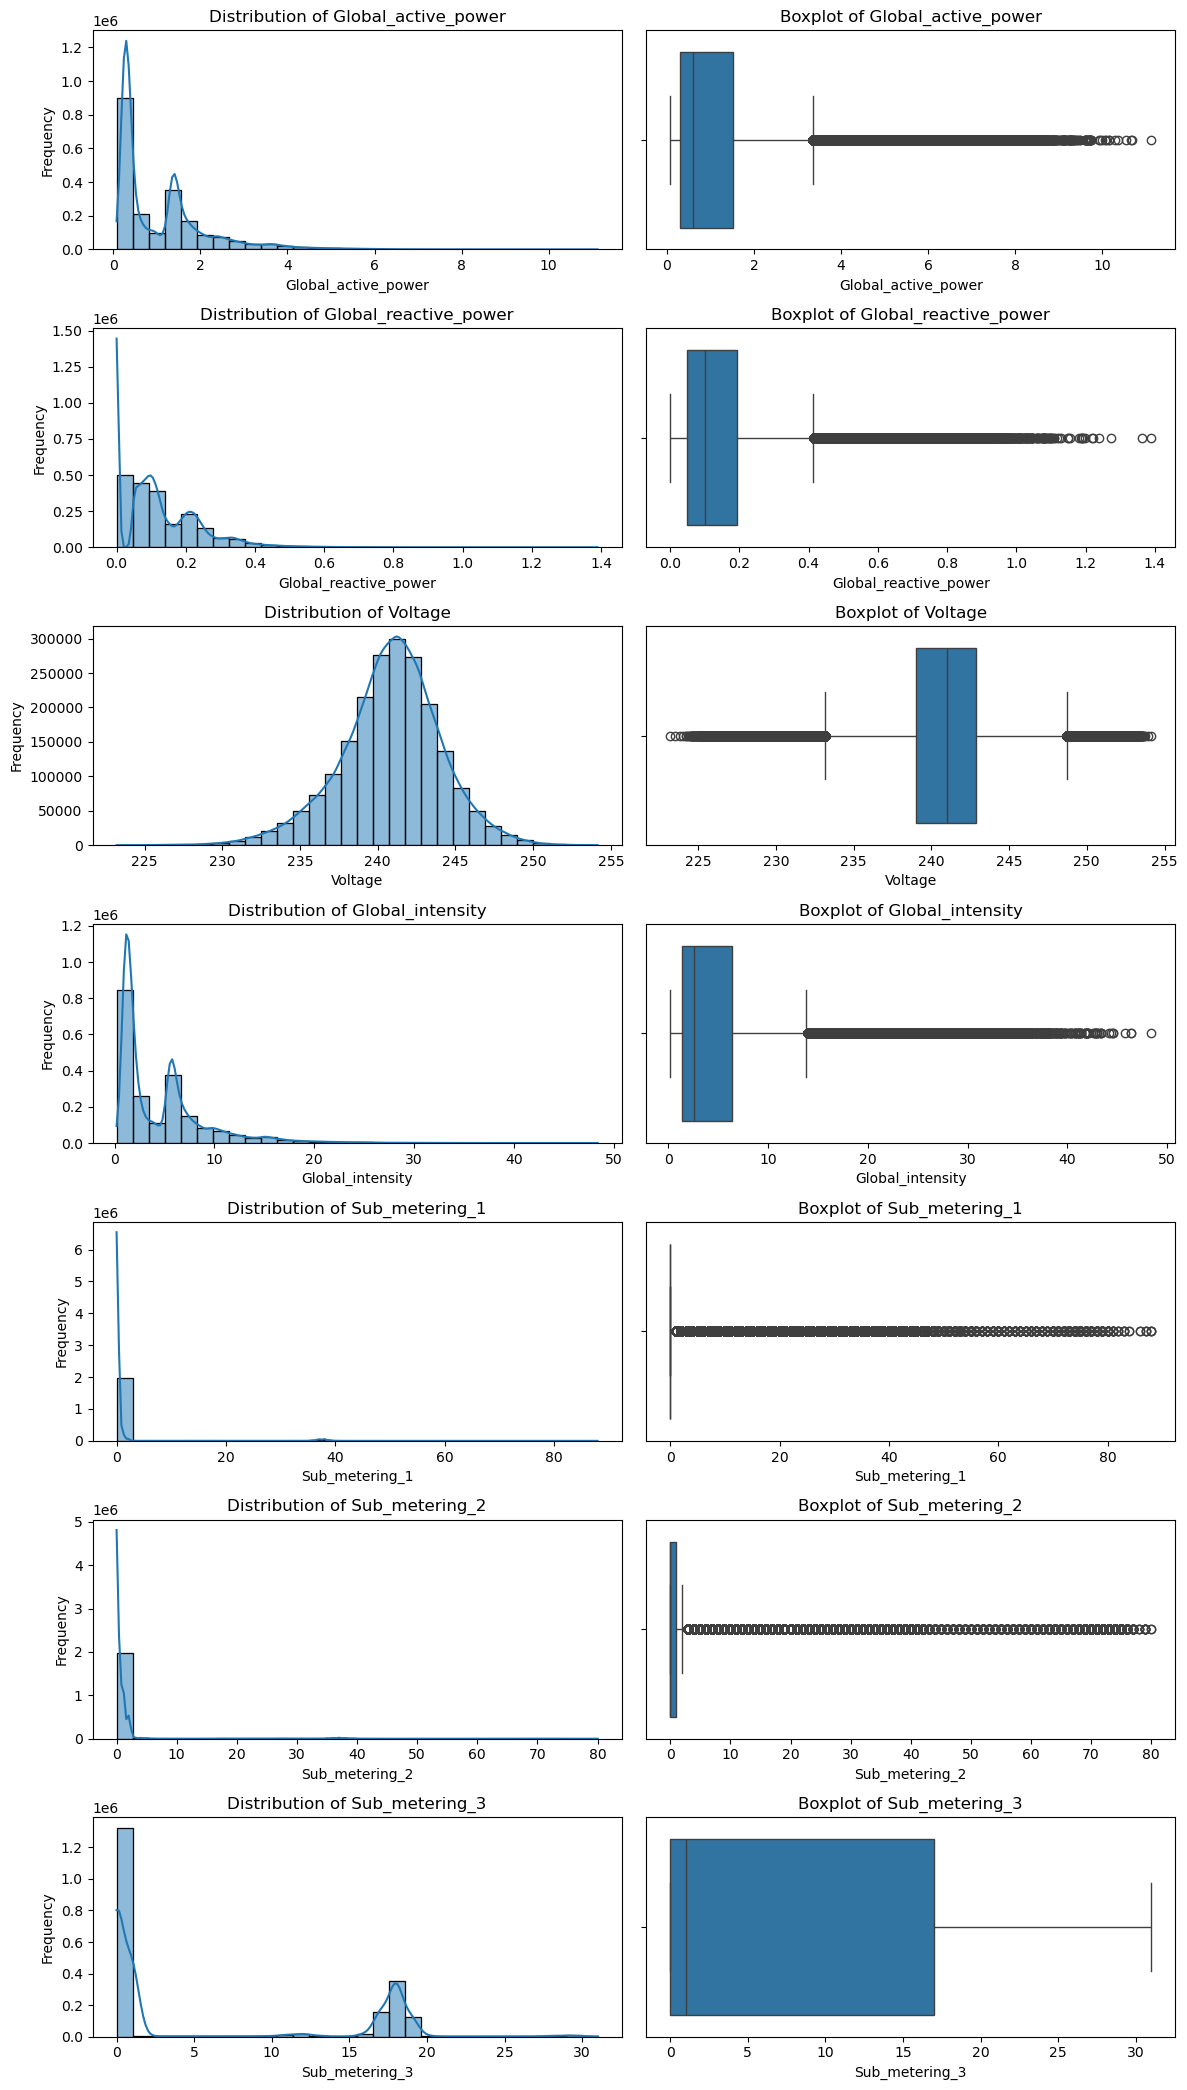

In [30]:

features = ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 
            'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']

plot_distribution_and_boxplot(df, features)


In [ ]:
'''
Conclusions: The above graphs represent outliers in the dataset
'''

## Handling missing values

In [33]:
# Imputing continuous variables with median
df['Global_active_power'].fillna(df['Global_active_power'].median(), inplace=True)
df['Global_reactive_power'].fillna(df['Global_reactive_power'].median(), inplace=True)
df['Voltage'].fillna(df['Voltage'].median(), inplace=True)
df['Global_intensity'].fillna(df['Global_intensity'].median(), inplace=True)
df['Sub_metering_1'].fillna(df['Sub_metering_1'].median(), inplace=True)
df['Sub_metering_2'].fillna(df['Sub_metering_2'].median(), inplace=True)
df['Sub_metering_3'].fillna(df['Sub_metering_3'].median(), inplace=True)


In [ ]:
'''
Conclusions: The dataset contains some missing values in the measurements (nearly 1,25% of the rows). So, we have imputed them with the median
'''

In [36]:
# Again checking for null values
df.isnull().sum()

Datetime                 0
Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

In [ ]:
'''
Conclusions: The Data is properly cleaned with no missing values
'''

## Outlier Detection after Handling missing values

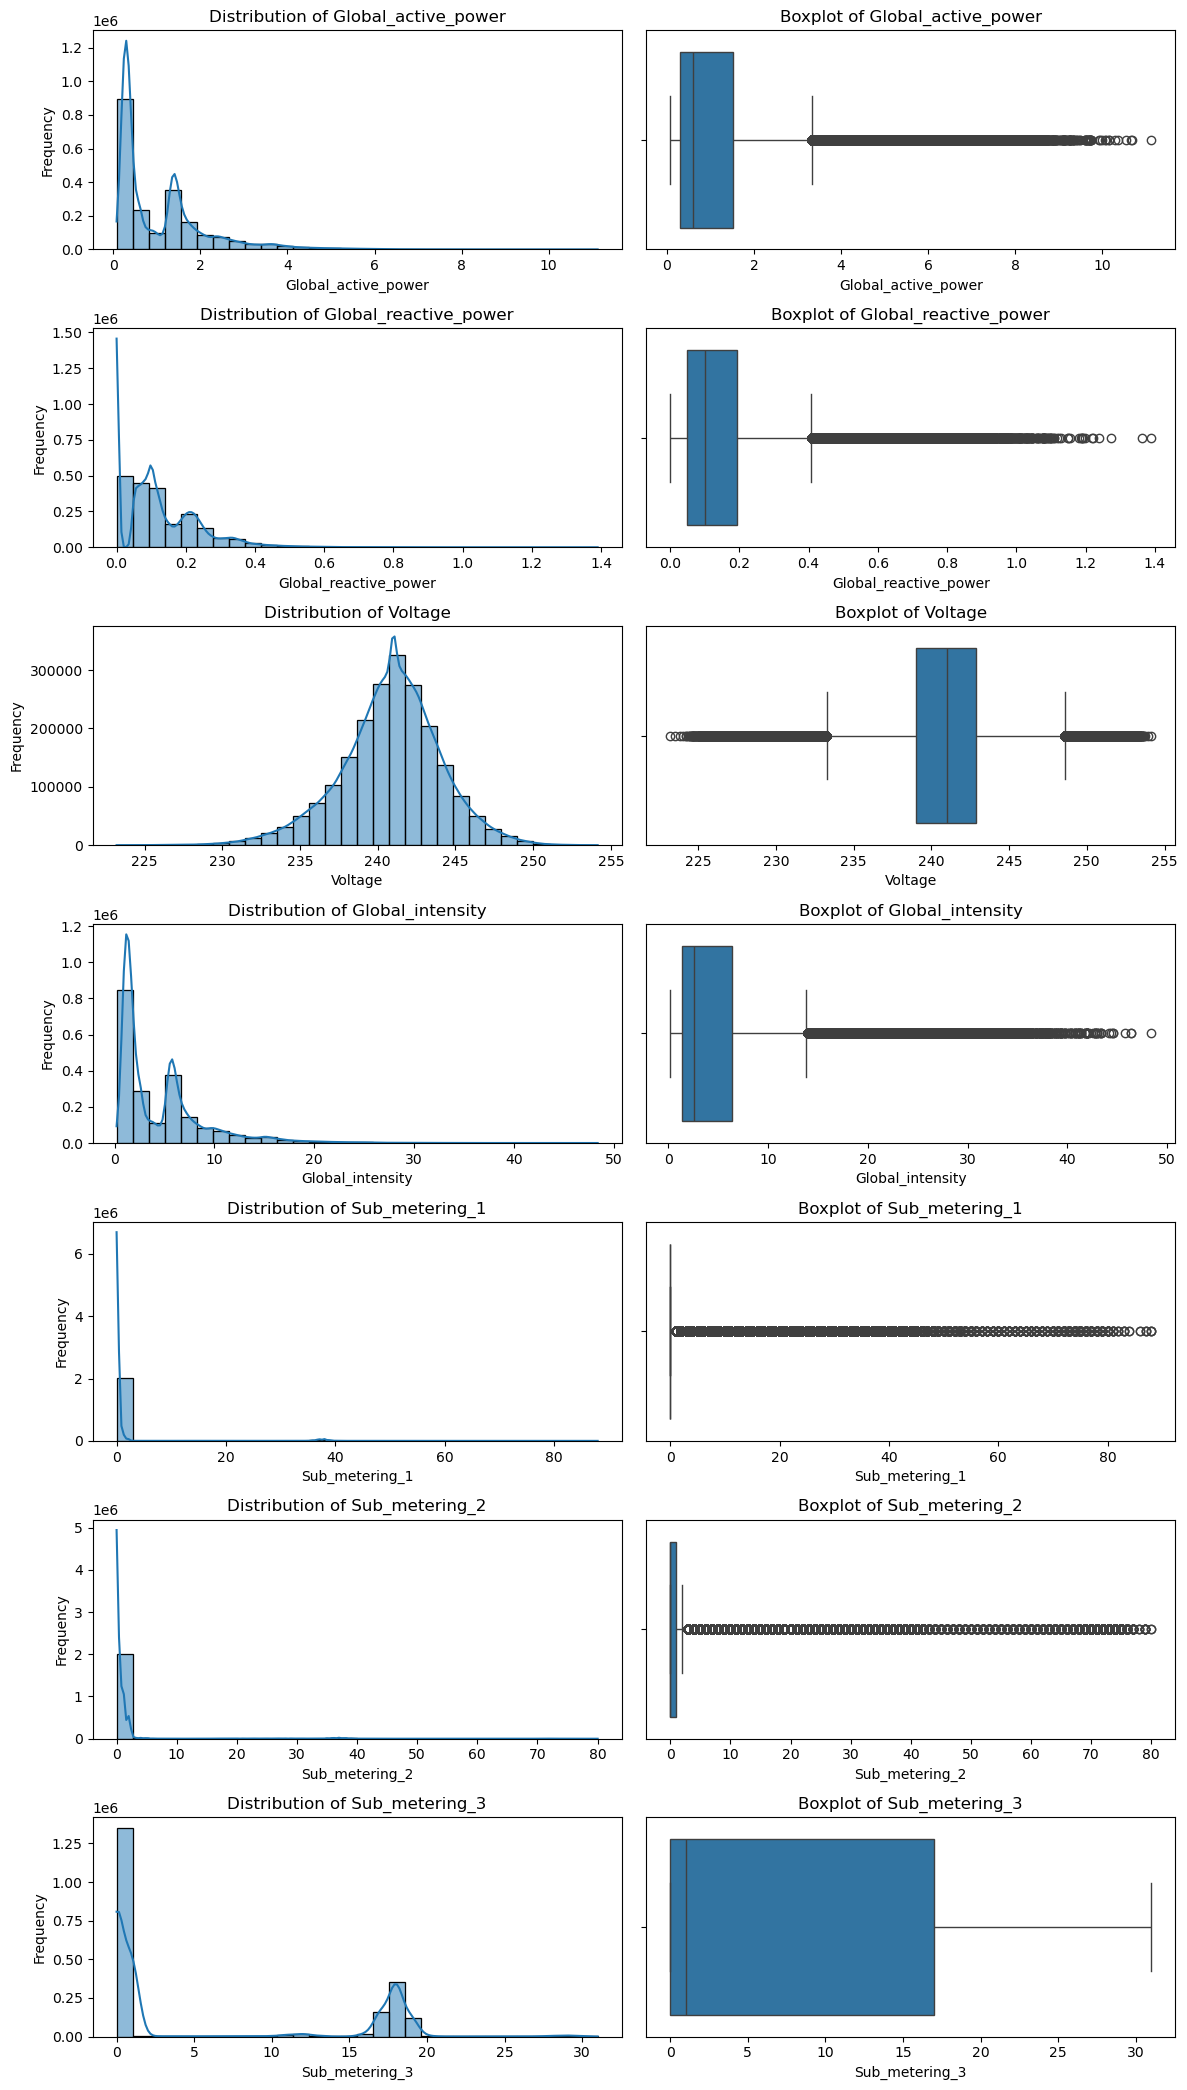

In [39]:
features = ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 
            'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']

plot_distribution_and_boxplot(df, features)

In [ ]:
'''
Conclusions:
We can see the outliers in the above graphs. The graphs are same as the ones plotted previously before imputation of missing values, 
which indicates that they are not affected by Handling missing values
Therefore, we need to handle the outliers in the data.
'''

## Handling Outliers in the data

In [44]:
# IQR Clipping Method
def iqr_clipping(df, column):
    Q1 = df[column].quantile(0.25)    # 25th Percentile
    Q3 = df[column].quantile(0.75)    # 75th Percentile
    IQR = Q3 - Q1                     # Interquartile Range
    lower_bound = Q1 - 1.5 * IQR      # Lower bound (outlier threshold)
    upper_bound = Q3 + 1.5 * IQR      # Upper bound (outlier threshold)
    df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)  # Clipping outliers

# Apply IQR clipping to selected skewed features
skewed_features = ['Global_active_power', 'Global_reactive_power', 'Global_intensity', 'Sub_metering_2']

for col in skewed_features:
    iqr_clipping(df, col)

# Quantile Winsorization Function
def quantile_winsorize(df, column, lower_quantile=0.05, upper_quantile=0.95):
    lower_bound = df[column].quantile(lower_quantile)
    upper_bound = df[column].quantile(upper_quantile)
    df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)

# Apply Winsorization to specific features
quantile_winsorize(df, 'Voltage', lower_quantile=0.05, upper_quantile=0.95)
quantile_winsorize(df, 'Sub_metering_1', lower_quantile=0.05, upper_quantile=0.95)  


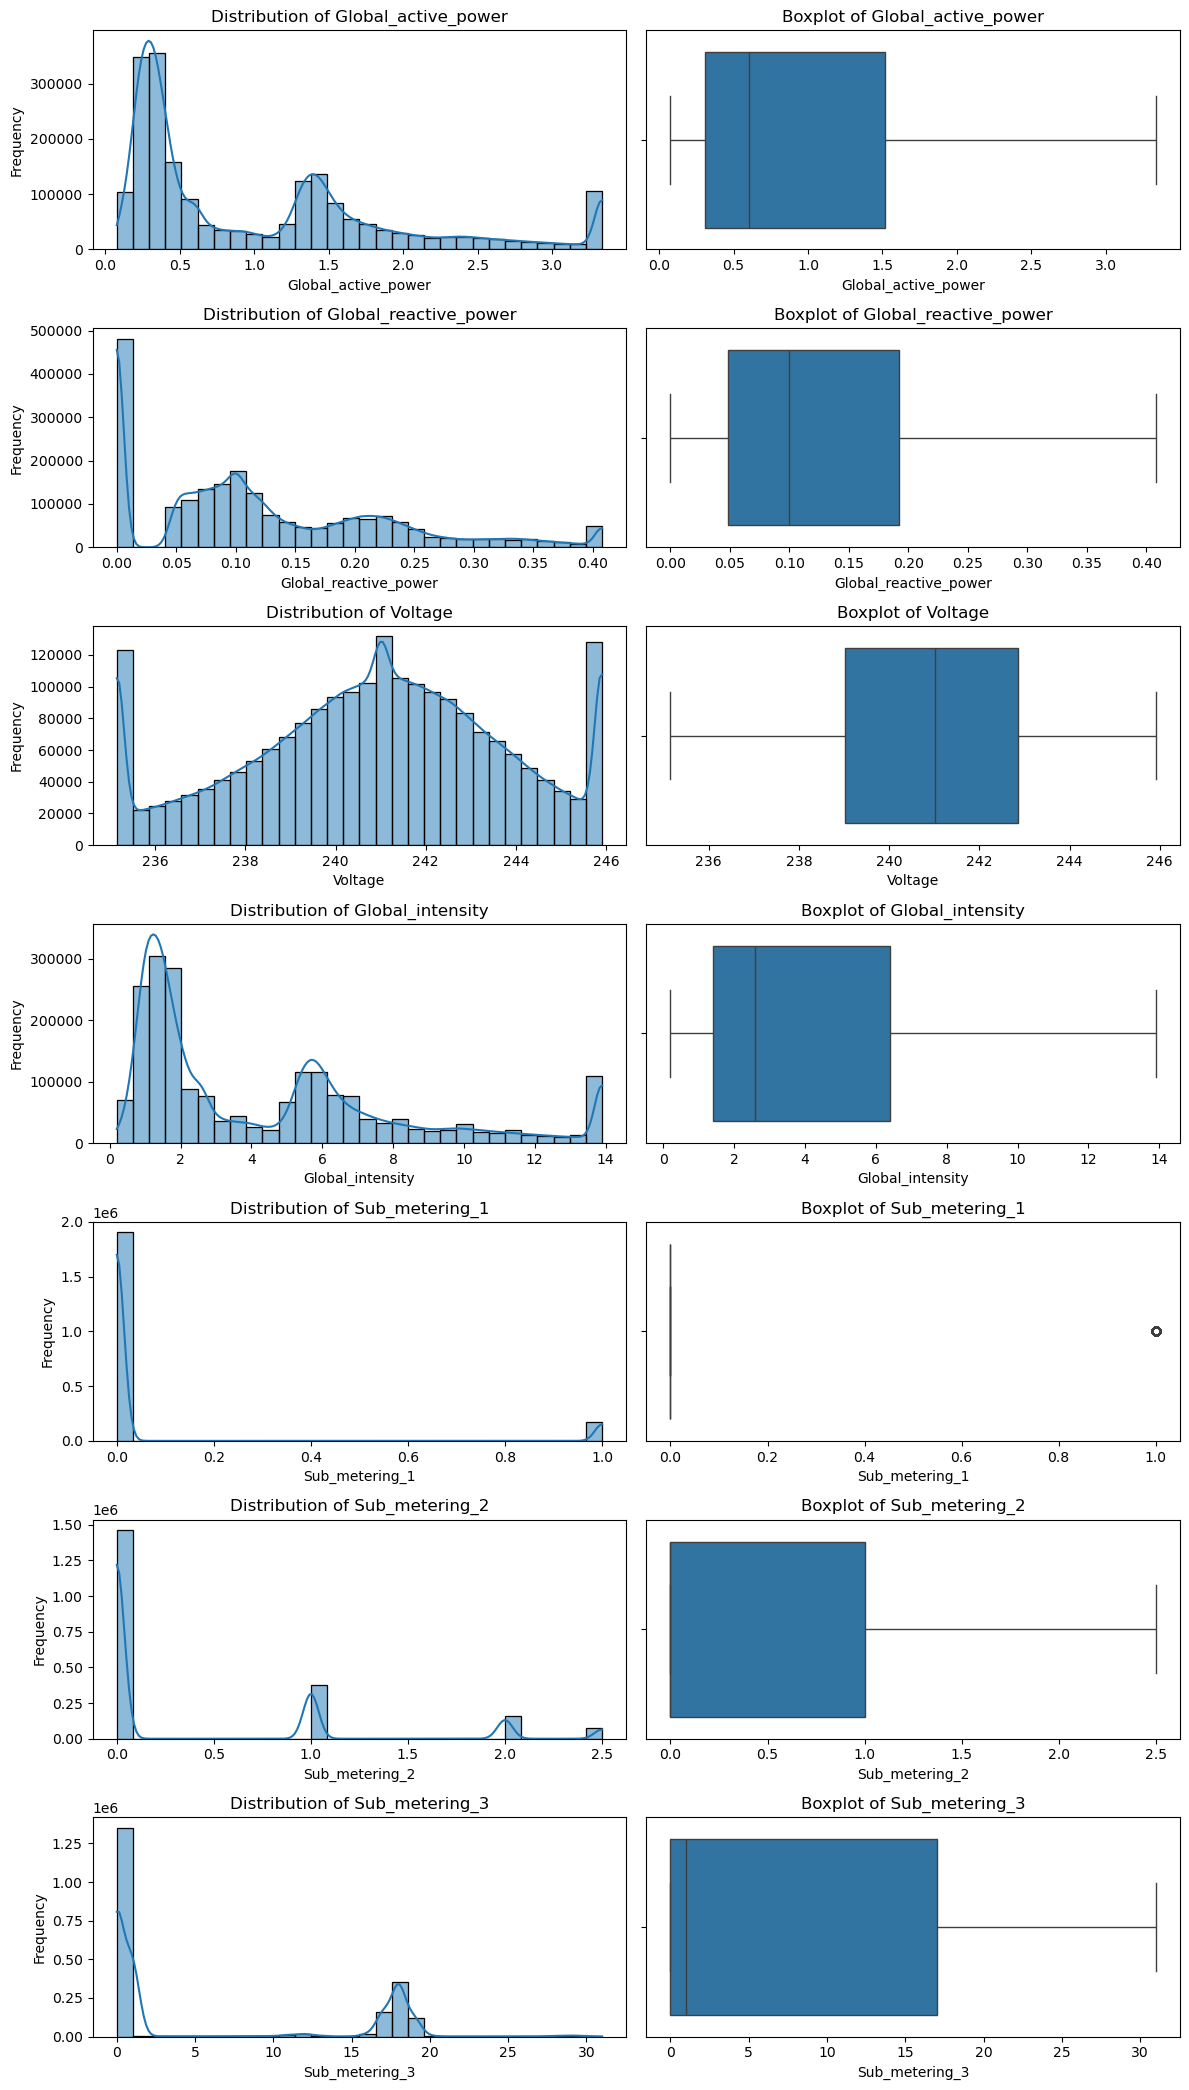

In [46]:
# Plotting the graphs again to check if the outliers are removed or not
features = ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 
            'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']

plot_distribution_and_boxplot(df, features)

In [ ]:
'''
Conclusions: The outliers from the data are removed and the data is now ready for analysis and building ML models
'''

In [49]:
# Checking if outlier in Sub_metering_1 is a problem or not
print(df["Sub_metering_1"].describe())
print(df["Sub_metering_1"].nlargest(5))  # See the highest values


count    2.075259e+06
mean     8.148621e-02
std      2.735804e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.000000e+00
Name: Sub_metering_1, dtype: float64
1019    1.0
1020    1.0
1021    1.0
1022    1.0
1023    1.0
Name: Sub_metering_1, dtype: float64


In [ ]:
'''
the top values are still reasonable (not extreme compared to the mean), keep the outlier
1.0 is not an extreme outlier.
It appears multiple times, meaning it's part of the data distribution.
It doesn’t seem to distort correlation or model performance.
'''

## Feature Engineering

In [52]:
# Create Additional Features

# Extract Useful Time Based Features
df['hour'] = df['Datetime'].dt.hour
df['day'] = df['Datetime'].dt.day
df['month'] = df['Datetime'].dt.month


In [54]:
# Daily Average of Global Active Power
daily_average = df.groupby(df["Datetime"].dt.date)["Global_active_power"].transform("mean")

# Assign back to the dataframe
df["daily_average"] = daily_average


In [56]:
# Peak hour
# Step 1: Compute hourly power consumption
hourly_sum = df.groupby([df["Datetime"].dt.date, df["Datetime"].dt.hour])["Global_active_power"].sum()

# Step 2: Identify the peak hour for each day
peak_hour_per_day = hourly_sum.groupby(level=0).idxmax().apply(lambda x: x[1])  # Extract the hour only

# Step 3: Map the peak hour back to the original dataframe
df["peak_hour"] = df["Datetime"].dt.date.map(peak_hour_per_day)


In [58]:
# Compute Rolling Average per day
df["rolling_average"] = (df.groupby(df["Datetime"].dt.date)["Global_active_power"]
                           .transform(lambda x: x.rolling(window=2, min_periods=1).mean()))

# Check for NaN values
print(df["rolling_average"].isnull().sum())

# If NaNs exist, impute them
#df["rolling_average"].fillna(df["rolling_average"].median(), inplace=True)



0


In [60]:
# Getting an idea about the NULL values
df.isnull().sum()

Datetime                 0
Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
hour                     0
day                      0
month                    0
daily_average            0
peak_hour                0
rolling_average          0
dtype: int64

In [62]:
df.head()

,Datetime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,hour,day,month,daily_average,peak_hour,rolling_average
0,2006-12-16 17:24:00,3.335,0.408,235.15,13.9,0.0,1.0,17.0,17,16,12,2.843134,19,3.335
1,2006-12-16 17:25:00,3.335,0.408,235.15,13.9,0.0,1.0,16.0,17,16,12,2.843134,19,3.335
2,2006-12-16 17:26:00,3.335,0.408,235.15,13.9,0.0,2.0,17.0,17,16,12,2.843134,19,3.335
3,2006-12-16 17:27:00,3.335,0.408,235.15,13.9,0.0,1.0,17.0,17,16,12,2.843134,19,3.335
4,2006-12-16 17:28:00,3.335,0.408,235.68,13.9,0.0,1.0,17.0,17,16,12,2.843134,19,3.335


In [64]:
df[['Datetime', 'hour','day','month','daily_average', 'peak_hour','rolling_average']].head(10)


,Datetime,hour,day,month,daily_average,peak_hour,rolling_average
0,2006-12-16 17:24:00,17,16,12,2.843134,19,3.335
1,2006-12-16 17:25:00,17,16,12,2.843134,19,3.335
2,2006-12-16 17:26:00,17,16,12,2.843134,19,3.335
3,2006-12-16 17:27:00,17,16,12,2.843134,19,3.335
4,2006-12-16 17:28:00,17,16,12,2.843134,19,3.335
5,2006-12-16 17:29:00,17,16,12,2.843134,19,3.335
6,2006-12-16 17:30:00,17,16,12,2.843134,19,3.335
7,2006-12-16 17:31:00,17,16,12,2.843134,19,3.335
8,2006-12-16 17:32:00,17,16,12,2.843134,19,3.335
9,2006-12-16 17:33:00,17,16,12,2.843134,19,3.335


In [66]:
# Checking the Datatypes again for the newly added features
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 14 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   Datetime               datetime64[ns]
 1   Global_active_power    float64       
 2   Global_reactive_power  float64       
 3   Voltage                float64       
 4   Global_intensity       float64       
 5   Sub_metering_1         float64       
 6   Sub_metering_2         float64       
 7   Sub_metering_3         float64       
 8   hour                   int32         
 9   day                    int32         
 10  month                  int32         
 11  daily_average          float64       
 12  peak_hour              int64         
 13  rolling_average        float64       
dtypes: datetime64[ns](1), float64(9), int32(3), int64(1)
memory usage: 197.9 MB


In [ ]:
'''
Conclusions: All the features have appropriate Datatypes
'''

In [69]:
# Checking for duplicate rows
df.duplicated().sum()

0

In [ ]:
'''
Conclusions: There are no duplicate rows present in the dataset
'''

## Outlier Detection in new Features

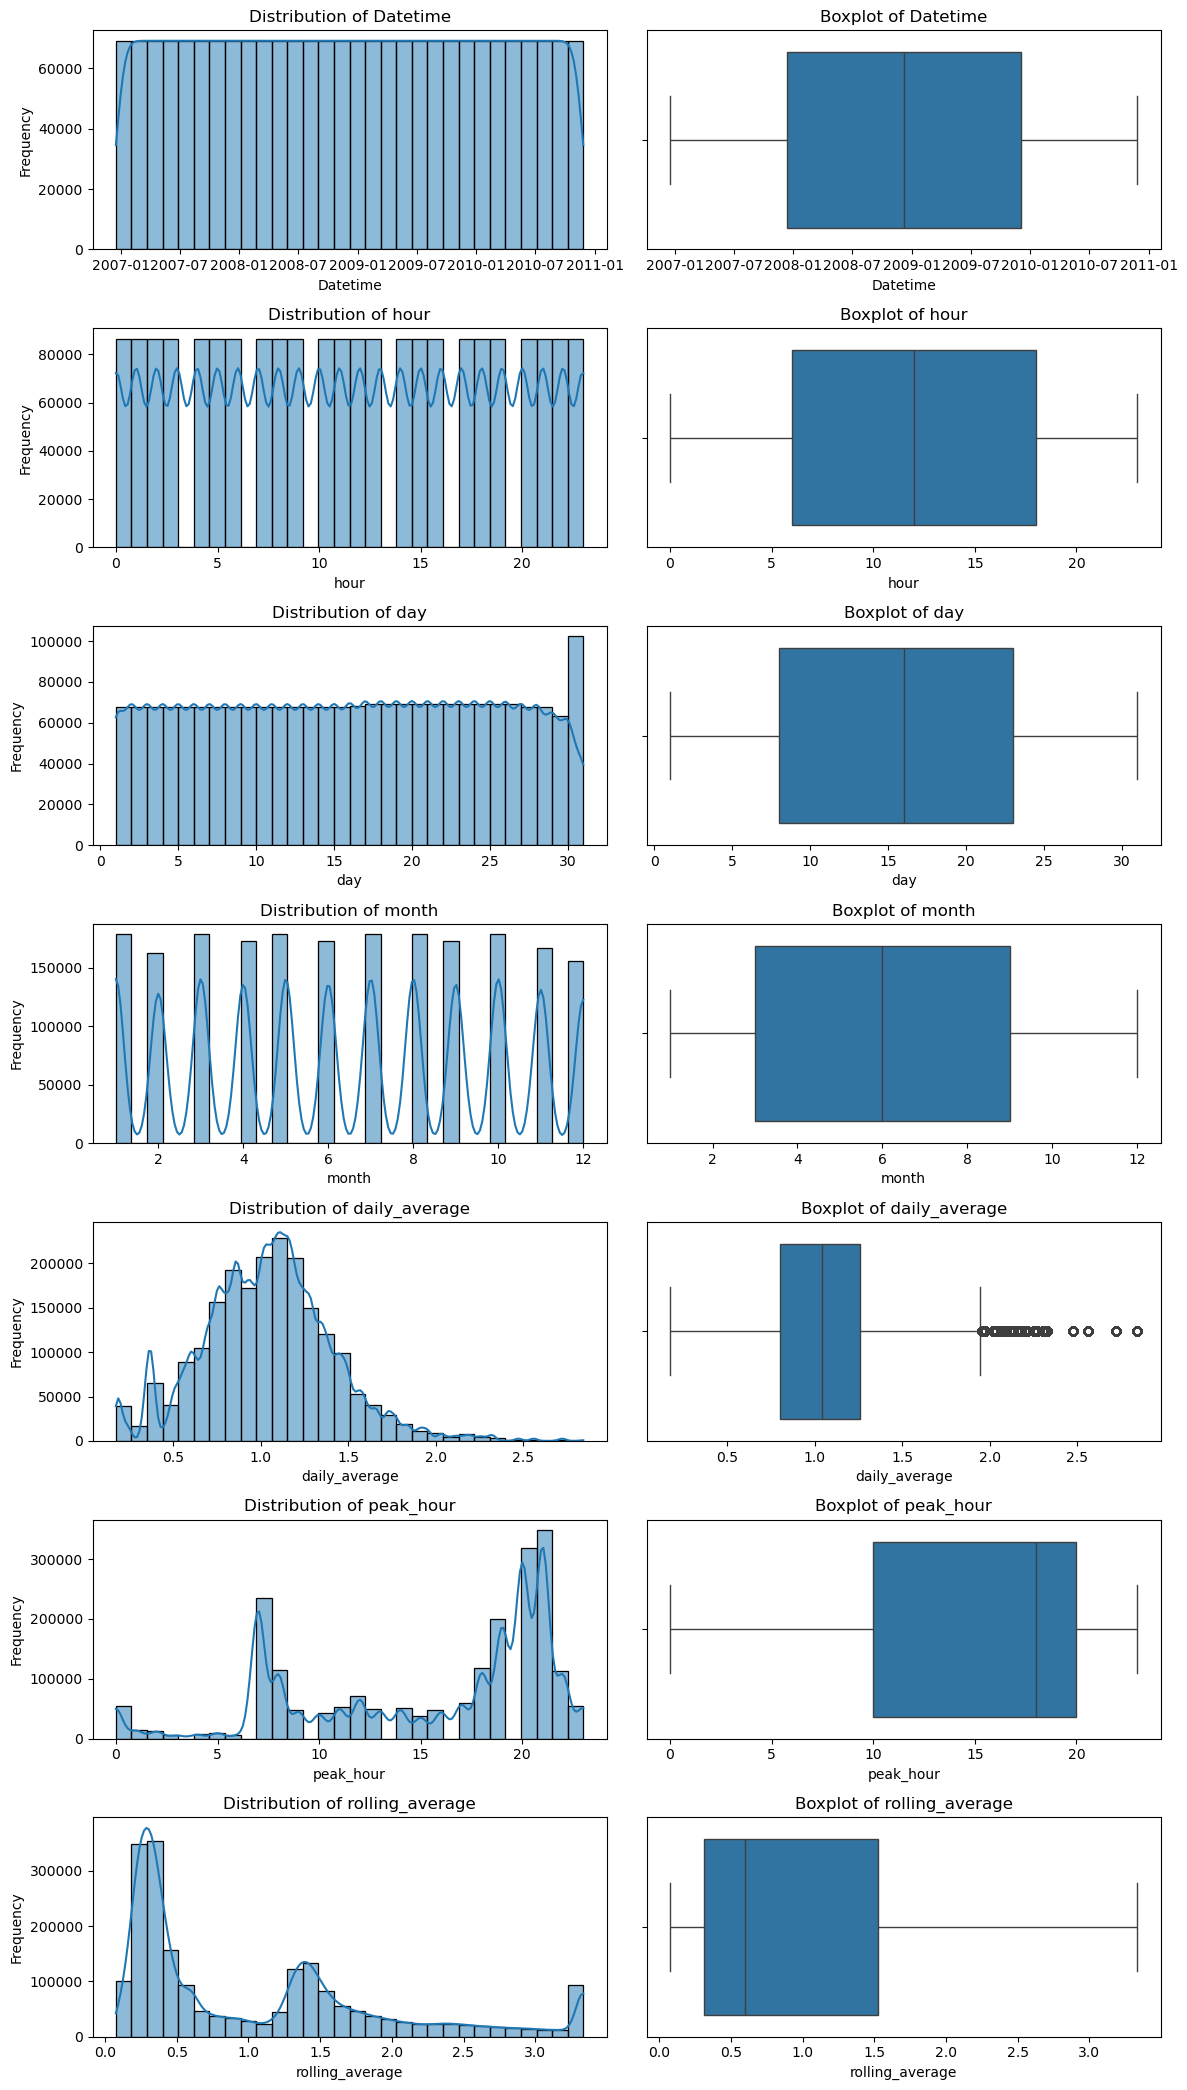

In [72]:
features = ['Datetime', 'hour','day','month','daily_average', 'peak_hour','rolling_average']
plot_distribution_and_boxplot(df, features)

In [ ]:
'''
Conclusions: The above graph shows outliers in the 'daily_average' feature
'''

In [75]:
# Handling outliers using IQR clipping method
def iqr_clipping(df, column):
    Q1 = df[column].quantile(0.25)  # 25th percentile
    Q3 = df[column].quantile(0.75)  # 75th percentile
    IQR = Q3 - Q1  # Interquartile range

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Clipping values outside the range
    df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)

# Apply IQR Clipping
iqr_clipping(df, 'daily_average')


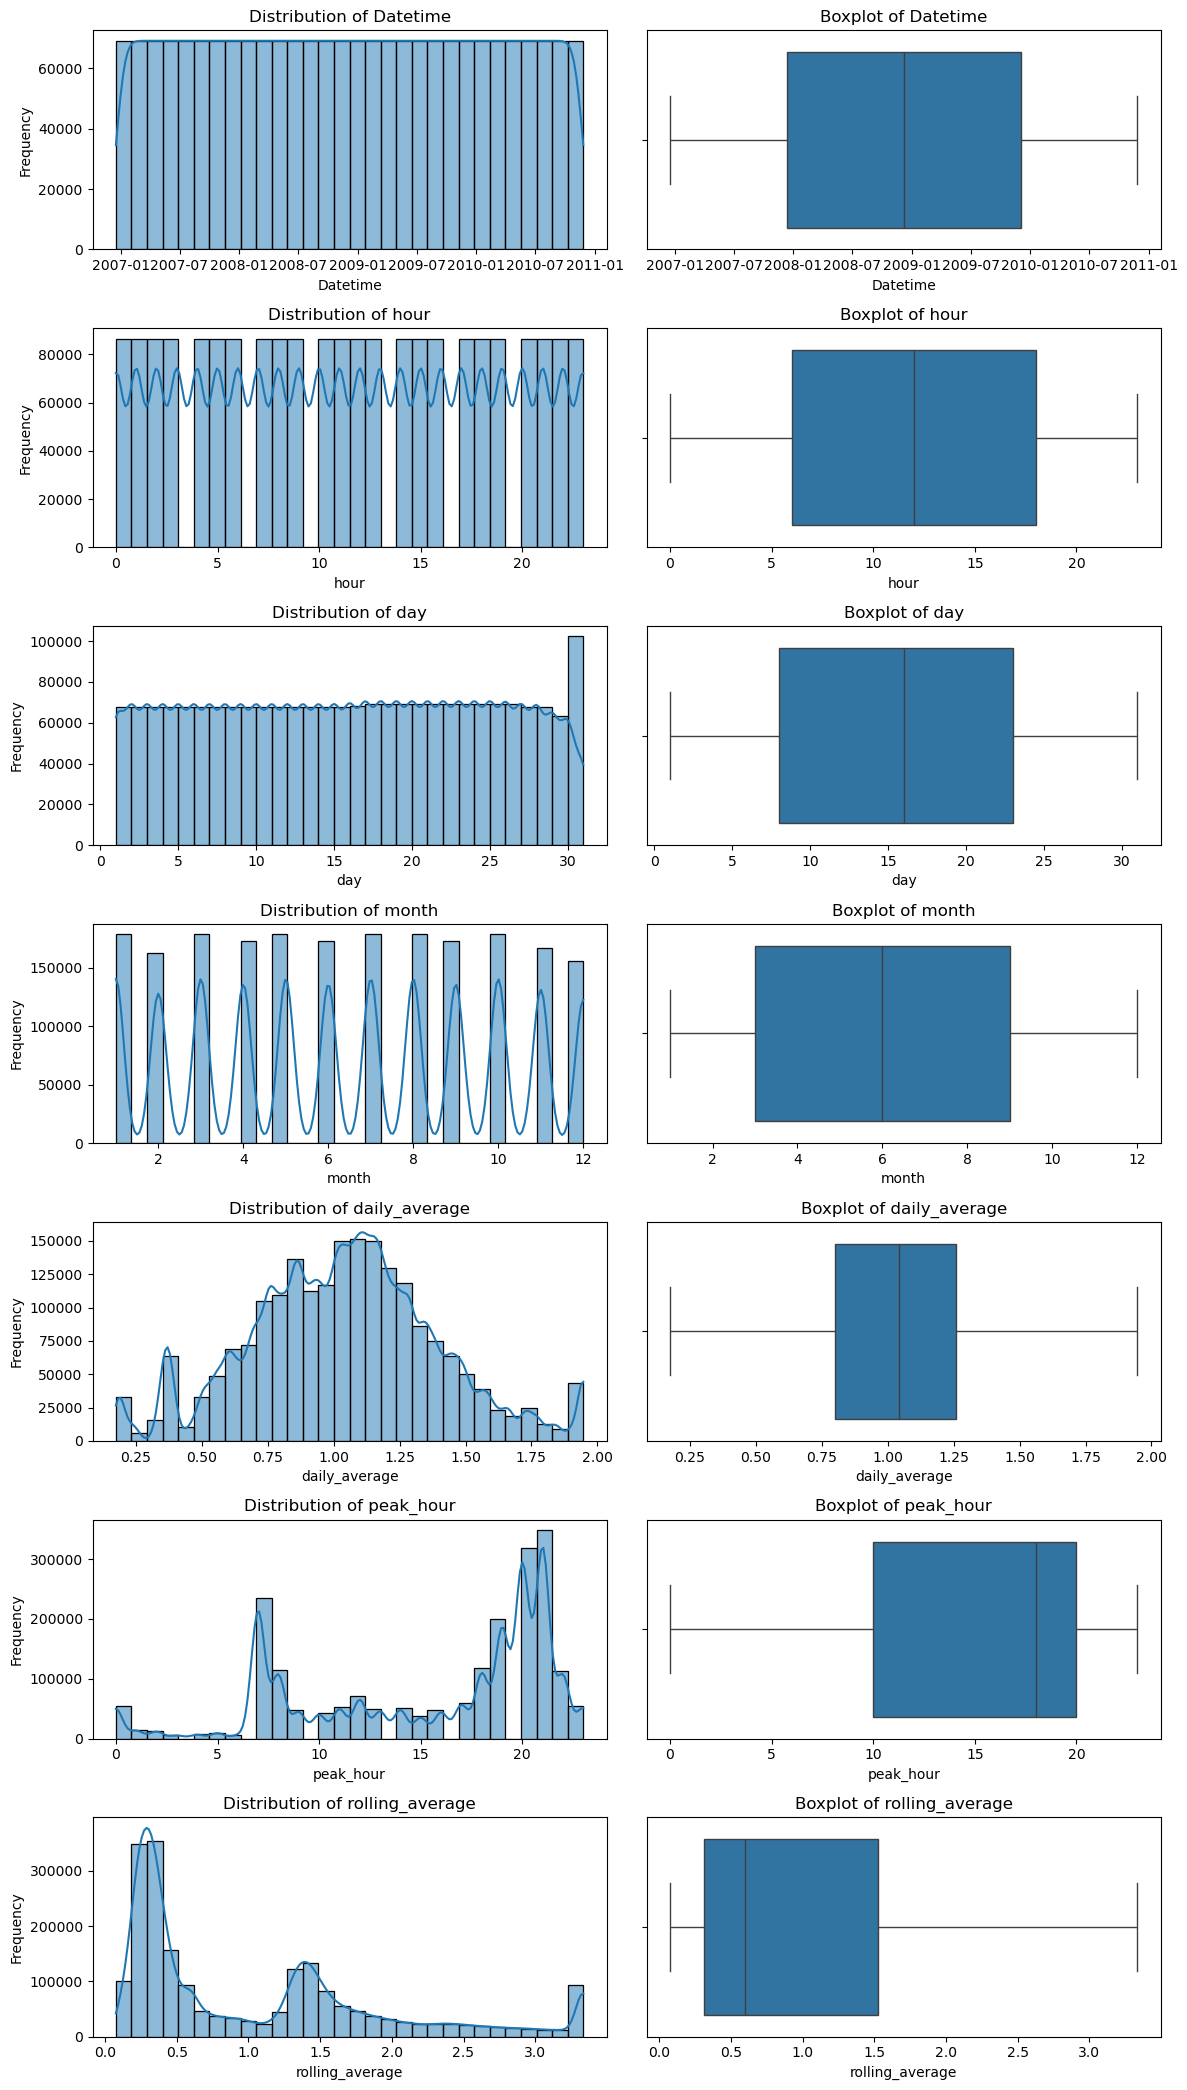

In [77]:
# Plotting the graphs again to check the outliers
features = ['Datetime', 'hour','day','month','daily_average', 'peak_hour','rolling_average']
plot_distribution_and_boxplot(df, features)

In [ ]:
'''
Conclusions: The outliers from new features are removed
'''

## Trend Analysis

## Time Series Plot (Trend Over Time)

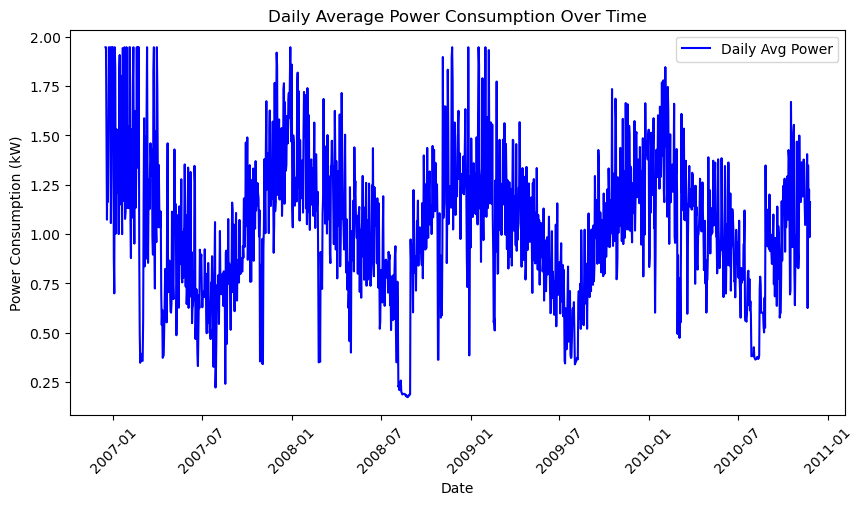

In [80]:
# Ensure Datetime is in correct format
df['Datetime'] = pd.to_datetime(df['Datetime'])

# Aggregate daily data
df_daily = df.groupby(df['Datetime'].dt.date).agg({'daily_average': 'mean'}).reset_index()
df_daily.rename(columns={'Datetime': 'Date'}, inplace=True)  # Rename column for clarity

# Plot the trend
plt.figure(figsize=(10,5))
sns.lineplot(x=df_daily['Date'], y=df_daily['daily_average'], label='Daily Avg Power', color='b')
plt.xlabel('Date')
plt.ylabel('Power Consumption (kW)')
plt.title('Daily Average Power Consumption Over Time')
plt.xticks(rotation=45)
plt.legend()
plt.show()


## Monthly Power Consumption Trend

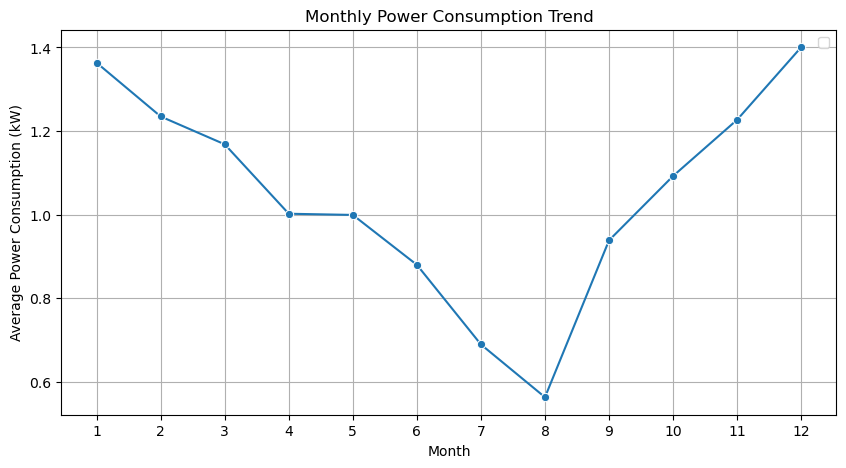

In [82]:
# Group by 'month' and calculate the mean of 'Global_active_power'
monthly_avg_power = df.groupby('month', as_index=False)['Global_active_power'].mean()

# Plot the monthly trend
plt.figure(figsize=(10, 5))
sns.lineplot(x=monthly_avg_power['month'], 
             y=monthly_avg_power['Global_active_power'], marker='o')

# Formatting the plot
plt.xlabel('Month')
plt.ylabel('Average Power Consumption (kW)')
plt.title('Monthly Power Consumption Trend')
plt.xticks(range(1, 13))  # Ensure x-axis ticks are months 1 to 12
plt.grid()
plt.legend()
plt.show()


## Weekly Average Power Consumption (Grouped by Week)

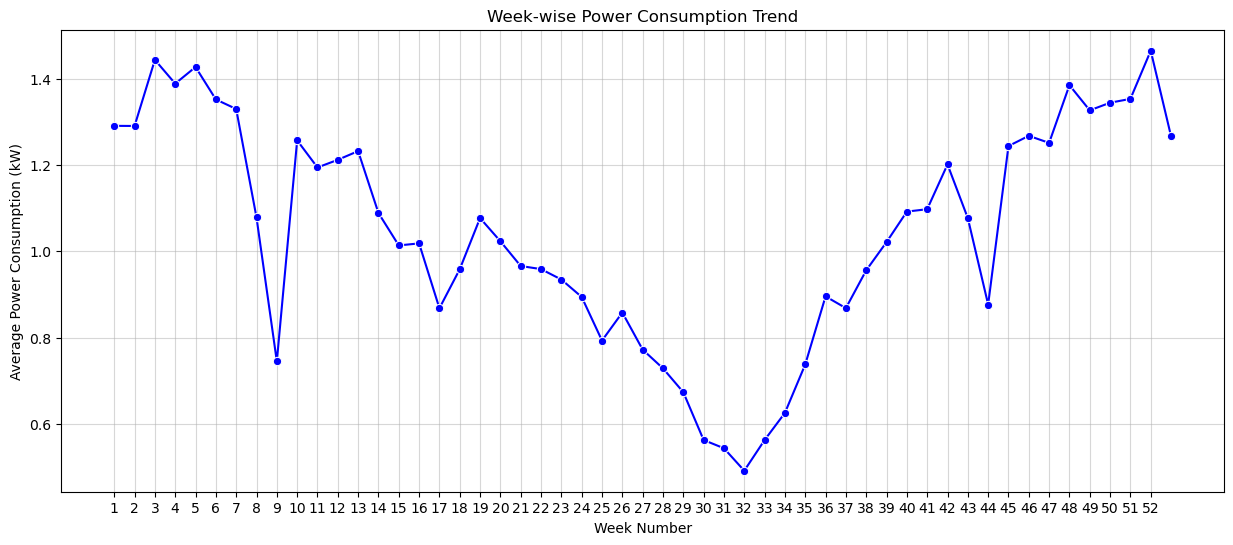

In [84]:
# Extract week number from Datetime
df['week'] = df['Datetime'].dt.isocalendar().week

# Group by week and calculate the mean power consumption
weekly_trend = df.groupby('week')['daily_average'].mean().reset_index()

# Plot the weekly trend
plt.figure(figsize=(15,6))
sns.lineplot(x=weekly_trend['week'], y=weekly_trend['daily_average'], marker='o', color='b')
plt.xlabel('Week Number')
plt.ylabel('Average Power Consumption (kW)')
plt.title('Week-wise Power Consumption Trend')
plt.xticks(range(1, 53))  # Weeks from 1 to 52
plt.grid(alpha=0.5)
plt.show()


##  Peak vs. Off-Peak Power Consumption

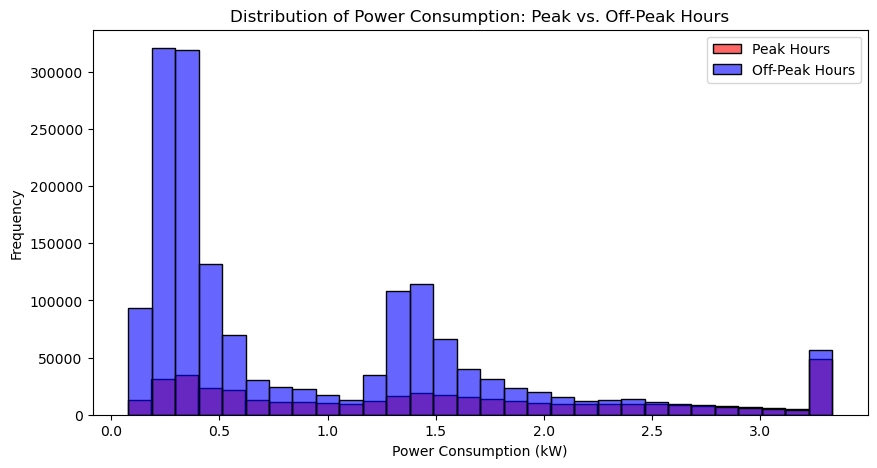

In [88]:
# Classify peak hours as hours between 6 PM (18) and 10 PM (22), else off-peak
df['is_peak_hour'] = df['hour'].apply(lambda x: 1 if 18 <= x <= 22 else 0)

# Now, you can plot the distributions for power consumption during peak and off-peak hours
plt.figure(figsize=(10, 5))

# Plot histogram for peak hours
sns.histplot(df[df['is_peak_hour'] == 1]['Global_active_power'], bins=30, color='red', label='Peak Hours', alpha=0.6)

# Plot histogram for off-peak hours
sns.histplot(df[df['is_peak_hour'] == 0]['Global_active_power'], bins=30, color='blue', label='Off-Peak Hours', alpha=0.6)

plt.xlabel('Power Consumption (kW)')
plt.ylabel('Frequency')
plt.title('Distribution of Power Consumption: Peak vs. Off-Peak Hours')
plt.legend()
plt.show()


## Model Selection and Training

## Linear Regression Model

In [90]:
# Separating the input feature and target variable
X = df[['Global_reactive_power','Voltage','Global_intensity','Sub_metering_1','Sub_metering_2','Sub_metering_3','hour','day','month','daily_average','peak_hour','rolling_average']]
y = df['Global_active_power']


## VIF to check for multicollinearity

In [ ]:
'''
VIF < 5 → No multicollinearity (Good to keep the feature).
VIF > 5 → High multicollinearity (Consider removing).
VIF > 10 → Severe multicollinearity (Definitely remove).
'''

In [93]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Compute VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

print(vif_data)


                  Feature         VIF
0   Global_reactive_power    3.021685
1                 Voltage   25.970008
2        Global_intensity  153.526915
3          Sub_metering_1    1.338264
4          Sub_metering_2    1.659644
5          Sub_metering_3    3.259435
6                    hour    4.294473
7                     day    4.228313
8                   month    4.611964
9           daily_average   12.316382
10              peak_hour    7.569515
11        rolling_average  156.354875


In [ ]:
'''
Conclusions: Voltage,Global_intensity,daily_average,rolling_average have very high multicollinearity. So, first we will remove 
Global_intensity and then recompute VIF
'''

In [96]:
# Recomputing VIF after removing Global_intensity
X = df[['Global_reactive_power','Voltage','Sub_metering_1','Sub_metering_2','Sub_metering_3','hour','day','month','daily_average','peak_hour','rolling_average']]
y = df['Global_active_power']


from statsmodels.stats.outliers_influence import variance_inflation_factor

# Compute VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

print(vif_data)


                  Feature        VIF
0   Global_reactive_power   2.922494
1                 Voltage  25.967674
2          Sub_metering_1   1.337746
3          Sub_metering_2   1.659633
4          Sub_metering_3   3.253751
5                    hour   4.294173
6                     day   4.228288
7                   month   4.611910
8           daily_average  12.307507
9               peak_hour   7.568697
10        rolling_average   7.122307


In [ ]:
'''
Conclusion: Voltage and Daily_average has high VIF. Recomputing VIF after removing Global_intensity and Voltage
'''

In [99]:
# Recomputing VIF by removing Voltage and Global_intensity
X = df[['Global_reactive_power','Sub_metering_1','Sub_metering_2','Sub_metering_3','hour','day','month','daily_average','peak_hour','rolling_average']]
y = df['Global_active_power']


from statsmodels.stats.outliers_influence import variance_inflation_factor

# Compute VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

print(vif_data)

                 Feature       VIF
0  Global_reactive_power  2.818045
1         Sub_metering_1  1.335348
2         Sub_metering_2  1.659552
3         Sub_metering_3  3.225308
4                   hour  3.778229
5                    day  3.696972
6                  month  3.767022
7          daily_average  8.591576
8              peak_hour  6.341752
9        rolling_average  6.905303


In [ ]:
'''
We can keep daily_average, peak_hour, and rolling_average in your model even though they have moderate multicollinearity.
Since their VIF values are below the critical threshold of 10, the level of multicollinearity isn't extreme enough to cause 
significant issues. These features could still provide valuable insights and predictive power for your model.
'''

In [102]:
# Perform train-test split on raw X
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

# Initialize the Scaler
scaler = StandardScaler()

# Fit on training data only
X_train = scaler.fit_transform(X_train)

# Transform test data using the same scaler
X_test = scaler.transform(X_test)


In [104]:
# Initialize the model
lr = LinearRegression()

# Fit the model using scaled training data
lr.fit(X_train, y_train)


LinearRegression()

In [106]:
# Taking the predictions from the model
y_train_pred = lr.predict(X_train)
y_pred = lr.predict(X_test)

In [108]:
# Model Evaluation on training data
lr_train_rmse = np.round(np.sqrt(metrics.mean_squared_error(y_train, y_train_pred)), 2)
lr_train_mae = np.round(metrics.mean_absolute_error(y_train, y_train_pred), 2)
lr_train_r2 = np.round(metrics.r2_score(y_train, y_train_pred), 2)

print("Training RMSE:", lr_train_rmse)
print("Training MAE:", lr_train_mae)
print("Training R² Score:", lr_train_r2)

# Model Evaluation on testing data
lr_test_rmse = np.round(np.sqrt(metrics.mean_squared_error(y_test, y_pred)), 2)
lr_test_mae = np.round(metrics.mean_absolute_error(y_test, y_pred), 2)
lr_test_r2 = np.round(metrics.r2_score(y_test, y_pred), 2)

print("\nTesting RMSE:", lr_test_rmse)
print("Testing MAE:", lr_test_mae)
print("Testing R² Score:", lr_test_r2)

Training RMSE: 0.11
Training MAE: 0.03
Training R² Score: 0.99

Testing RMSE: 0.11
Testing MAE: 0.03
Testing R² Score: 0.99


In [ ]:
'''
Conclusions:
Interpretation:
R² Score: An R² score of 0.99 means that 99% of the variance in the target variable (power consumption) is explained by the features in 
the model. This is an excellent result, indicating a strong fit.

RMSE and MAE: Both training and testing RMSE and MAE are quite low, suggesting that the differences between the predicted and actual values
are minimal.

Consistency between Training and Testing: The metrics for both the training and testing sets are very close to each other, which indicates 
that your model generalizes well and is not overfitting.
'''

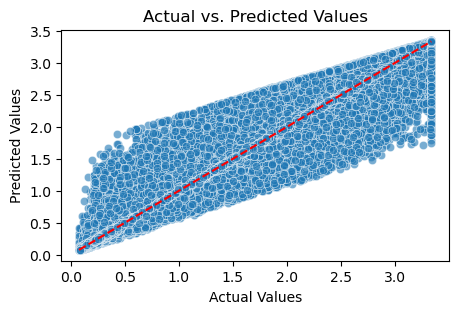

In [111]:


# Assuming y_test and y_pred are your actual and predicted values respectively

plt.figure(figsize=(5, 3))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()


In [113]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(lr, X, y, cv=5, scoring='r2')
print("Cross-Validation R² Scores:", scores)
print("Average CV R² Score:", np.mean(scores))


Cross-Validation R² Scores: [0.98386946 0.98762209 0.98842023 0.9866719  0.98635381]
Average CV R² Score: 0.9865874962304491


## Random Forest Regressor

In [115]:
# Separating the input feature and target variable
X = df[['Global_reactive_power','Global_intensity','Voltage','Sub_metering_1','Sub_metering_2','Sub_metering_3','hour','day','month','daily_average','peak_hour','rolling_average']]
y = df['Global_active_power']
# Performing Train Test split
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size = 0.2, random_state = 5)

In [117]:

# Creating the model
model = RandomForestRegressor()

# Fitting the model
model.fit(X_train,y_train)

RandomForestRegressor()

In [121]:
# Taking Predictions from the model
y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

In [123]:
# Model Evaluation on training data
rf1_train_rmse = np.round(np.sqrt(metrics.mean_squared_error(y_train, y_train_pred)), 2)
rf1_train_mae = np.round(metrics.mean_absolute_error(y_train, y_train_pred), 2)
rf1_train_r2 = np.round(metrics.r2_score(y_train, y_train_pred), 2)

print("Training RMSE:", rf1_train_rmse)
print("Training MAE:", rf1_train_mae)
print("Training R² Score:", rf1_train_r2)

# Model Evaluation on testing data
rf1_test_rmse = np.round(np.sqrt(metrics.mean_squared_error(y_test, y_pred)), 2)
rf1_test_mae = np.round(metrics.mean_absolute_error(y_test, y_pred), 2)
rf1_test_r2 = np.round(metrics.r2_score(y_test, y_pred), 2)

print("\nTesting RMSE:", rf1_test_rmse)
print("Testing MAE:", rf1_test_mae)
print("Testing R² Score:", rf1_test_r2)

Training RMSE: 0.01
Training MAE: 0.0
Training R² Score: 1.0

Testing RMSE: 0.02
Testing MAE: 0.01
Testing R² Score: 1.0


In [ ]:
'''
Conclusions: The model is overfitting
'''

In [125]:
import pandas as pd

feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': model.feature_importances_})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
print(feature_importances)


                  Feature  Importance
1        Global_intensity    0.992400
11        rolling_average    0.006664
2                 Voltage    0.000203
0   Global_reactive_power    0.000181
5          Sub_metering_3    0.000148
9           daily_average    0.000104
6                    hour    0.000093
7                     day    0.000057
10              peak_hour    0.000047
8                   month    0.000042
4          Sub_metering_2    0.000031
3          Sub_metering_1    0.000030


## Performing Hyperparameter Optimization using RandomizedSearchCV

In [128]:

params = {
    'n_estimators': [50, 100],      # Conservative number of trees
    'max_depth': [3, 4],            # Shallower trees to reduce overfitting
    'min_samples_split': [30, 40],  # Ensure adequate samples per split
    'min_samples_leaf': [10, 20],   # Larger leaves to reduce tree complexity
    'criterion': ['squared_error'], # Loss function for regression
    'max_features': ['sqrt']        # Random subset of features for each tree
}

# Initialize RandomForestRegressor with bootstrapping enabled and oob_score
clf = RandomForestRegressor(bootstrap=True, oob_score=True)



In [130]:
# Initialize RandomForestRegressor
clf = RandomForestRegressor()

# Using RandomizedSearchCV for hyperparameter tuning
random_search = RandomizedSearchCV(estimator=clf,
    param_distributions=params,
    n_iter=10,  # Try lowering this
    cv=3,
    verbose=1,
    random_state=42)

random_search.fit(X_train, y_train)



Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(),
                   param_distributions={'criterion': ['squared_error'],
                                        'max_depth': [3, 4],
                                        'max_features': ['sqrt'],
                                        'min_samples_leaf': [10, 20],
                                        'min_samples_split': [30, 40],
                                        'n_estimators': [50, 100]},
                   random_state=42, verbose=1)

In [134]:
# Getting the best parameters from the grid search
best_params = random_search.best_params_
print("Best Parameters:", best_params)     


Best Parameters: {'n_estimators': 100, 'min_samples_split': 40, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'max_depth': 4, 'criterion': 'squared_error'}


In [136]:
# Fitting the optimal model with best parameters
clf_optimized = RandomForestRegressor(**best_params)

# Fit the optimized model
clf_optimized.fit(X_train, y_train)


RandomForestRegressor(max_depth=4, max_features='sqrt', min_samples_leaf=10,
                      min_samples_split=40)

In [138]:
# Taking the predictions from the model
y_pred = clf_optimized.predict(X_test)
y_train_pred = clf_optimized.predict(X_train)

In [140]:
# Model Evaluation on training data
rf_train_rmse = np.round(np.sqrt(metrics.mean_squared_error(y_train, y_train_pred)), 2)
rf_train_mae = np.round(metrics.mean_absolute_error(y_train, y_train_pred), 2)
rf_train_r2 = np.round(metrics.r2_score(y_train, y_train_pred), 2)

print("Training RMSE:", rf_train_rmse)
print("Training MAE:", rf_train_mae)
print("Training R² Score:", rf_train_r2)

# Model Evaluation on testing data
rf_test_rmse = np.round(np.sqrt(metrics.mean_squared_error(y_test, y_pred)), 2)
rf_test_mae = np.round(metrics.mean_absolute_error(y_test, y_pred), 2)
rf_test_r2 = np.round(metrics.r2_score(y_test, y_pred), 2)

print("\nTesting RMSE:", rf_test_rmse)
print("Testing MAE:", rf_test_mae)
print("Testing R² Score:", rf_test_r2)

Training RMSE: 0.16
Training MAE: 0.11
Training R² Score: 0.97

Testing RMSE: 0.16
Testing MAE: 0.11
Testing R² Score: 0.97


In [ ]:
'''
Conclusions: These metrics indicate a good model that generalizes well without overfitting.
'''

## Gradient Boosting Regressor Model

In [143]:
# Separating the input features and the target variable
X = df[['Global_reactive_power','Global_intensity','Voltage','Sub_metering_1','Sub_metering_2','Sub_metering_3','hour','day','month','daily_average','peak_hour','rolling_average']]
y = df['Global_active_power']

# Performing the train test split
X_train, X_test, y_train,y_test = train_test_split(X,y, test_size = 0.2, random_state = 42) 

In [145]:
# Creating the model
model = GradientBoostingRegressor()

# Fitting the model
model.fit(X_train,y_train)

GradientBoostingRegressor()

In [149]:
# Taking predictions from the model
y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

In [150]:
# Model Evaluation on training data
gb1_train_rmse = np.round(np.sqrt(metrics.mean_squared_error(y_train, y_train_pred)), 2)
gb1_train_mae = np.round(metrics.mean_absolute_error(y_train, y_train_pred), 2)
gb1_train_r2 = np.round(metrics.r2_score(y_train, y_train_pred), 2)

print("Training RMSE:", gb1_train_rmse)
print("Training MAE:", gb1_train_mae)
print("Training R² Score:", gb1_train_r2)

# Model Evaluation on testing data
gb1_test_rmse = np.round(np.sqrt(metrics.mean_squared_error(y_test, y_pred)), 2)
gb1_test_mae = np.round(metrics.mean_absolute_error(y_test, y_pred), 2)
gb1_test_r2 = np.round(metrics.r2_score(y_test, y_pred), 2)

print("\nTesting RMSE:", gb1_test_rmse)
print("Testing MAE:", gb1_test_mae)
print("Testing R² Score:", gb1_test_r2)

Training RMSE: 0.03
Training MAE: 0.02
Training R² Score: 1.0

Testing RMSE: 0.03
Testing MAE: 0.02
Testing R² Score: 1.0


In [102]:
'''
Conclusions:
Overfitting Concerns: Near-perfect R² and low error metrics suggest overfitting, where the model may be learning noise in the training 
data rather than generalizing. Although the testing metrics are also strong, this could indicate the model has memorized the data, raising
concerns about performance on new datasets.

'''

'\nConclusions:\n'

# Performing Hyper parameter optimization to reduce overfitting using RandomizedSearchCV

In [156]:
params = {
    'n_estimators': [150, 200],  # Moderate number of trees
    'learning_rate': [0.01, 0.02],  
    'max_depth': [4],  
    'min_samples_split': [20],  
    'min_samples_leaf': [10, 15],  
    'subsample': [0.9],  
    'max_features': ['sqrt']
}


In [158]:
# Initialize the model
model = GradientBoostingRegressor()

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=model, 
    param_distributions=params, 
    n_iter=5,  # Number of parameter settings sampled
    scoring='neg_mean_squared_error',  # Use MSE as scoring
    cv=2,  # 2-fold cross-validation
    verbose=1, 
    random_state=42
)

# Fit the model
random_search.fit(X_train, y_train)

Fitting 2 folds for each of 5 candidates, totalling 10 fits


RandomizedSearchCV(cv=2, estimator=GradientBoostingRegressor(), n_iter=5,
                   param_distributions={'learning_rate': [0.01, 0.02],
                                        'max_depth': [4],
                                        'max_features': ['sqrt'],
                                        'min_samples_leaf': [10, 15],
                                        'min_samples_split': [20],
                                        'n_estimators': [150, 200],
                                        'subsample': [0.9]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=1)

In [160]:
# Getting the best parameters from the grid search
best_params = random_search.best_params_
print("Best Parameters:", best_params)

Best Parameters: {'subsample': 0.9, 'n_estimators': 200, 'min_samples_split': 20, 'min_samples_leaf': 15, 'max_features': 'sqrt', 'max_depth': 4, 'learning_rate': 0.02}


In [162]:
# Fitting the optimal model with best parameters
model_optimized = GradientBoostingRegressor(**best_params)

# Fit the optimized model
model_optimized.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.02, max_depth=4, max_features='sqrt',
                          min_samples_leaf=15, min_samples_split=20,
                          n_estimators=200, subsample=0.9)

In [165]:
# Taking the predictions from the model
y_pred = model_optimized.predict(X_test)
y_train_pred = model_optimized.predict(X_train)

In [167]:
# Model Evaluation on training data
gb_train_rmse = np.round(np.sqrt(metrics.mean_squared_error(y_train, y_train_pred)), 2)
gb_train_mae = np.round(metrics.mean_absolute_error(y_train, y_train_pred), 2)
gb_train_r2 = np.round(metrics.r2_score(y_train, y_train_pred), 2)

print("Training RMSE:", gb_train_rmse)
print("Training MAE:", gb_train_mae)
print("Training R² Score:", gb_train_r2)

# Model Evaluation on testing data
gb_test_rmse = np.round(np.sqrt(metrics.mean_squared_error(y_test, y_pred)), 2)
gb_test_mae = np.round(metrics.mean_absolute_error(y_test, y_pred), 2)
gb_test_r2 = np.round(metrics.r2_score(y_test, y_pred), 2)

print("\nTesting RMSE:", gb_test_rmse)
print("Testing MAE:", gb_test_mae)
print("Testing R² Score:", gb_test_r2)

Training RMSE: 0.07
Training MAE: 0.04
Training R² Score: 0.99

Testing RMSE: 0.07
Testing MAE: 0.04
Testing R² Score: 0.99


In [110]:
'''
Conclusions:
1. Reduced Overfitting: After tuning, the slight increase in training error indicates that the model is no longer overfitting, as it avoids
perfectly capturing the training data's noise and patterns.
2. Improved Generalization: The consistent performance between training and testing after tuning shows that the model now generalizes 
better to new data, maintaining high accuracy while being more resilient to overfitting. This reduces the likelihood of performance drop on unseen datasets.
'''

'\nConclusions:\n'

## Neural Network Model

In [171]:
# Separating the input features and the target variable
X = df[['Global_reactive_power','Global_intensity','Voltage','Sub_metering_1','Sub_metering_2','Sub_metering_3','hour','day','month','daily_average','peak_hour','rolling_average']]
y = df['Global_active_power']

# Performing the train test split
X_train, X_test, y_train,y_test = train_test_split(X,y, test_size = 0.2, random_state = 42) 

In [174]:
# Step 1: Data Preprocessing (Scaling)
scaler = StandardScaler()  # Normalize the data since neural networks perform better with scaled data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [176]:
# Building the Neural Network Model
model = Sequential()

# Add input layer and the first hidden layer
model.add(Dense(128, input_dim=X_train_scaled.shape[1], activation='relu'))

# Add second hidden layer
model.add(Dense(64, activation='relu'))

# Add output layer (for regression, we use 1 output neuron with no activation or linear activation)
model.add(Dense(1, activation='linear'))

In [178]:
# Step 3: Compiling the Model
model.compile(optimizer='adam', loss='mean_squared_error')

In [180]:
# Step 4: Training the Model
history = model.fit(X_train_scaled, y_train, 
                    epochs=50,  # Number of times the entire dataset passes through the model
                    batch_size=32,  # Number of samples processed before updating model weights
                    validation_split=0.2,  # Use 20% of training data for validation
                    verbose=1  # Show the progress
                   )

Epoch 1/50
41506/41506 ━━━━━━━━━━━━━━━━━━━━ 13s 313us/step - loss: 0.0057 - val_loss: 0.0011
Epoch 2/50
41506/41506 ━━━━━━━━━━━━━━━━━━━━ 13s 311us/step - loss: 7.9480e-04 - val_loss: 7.0328e-04
Epoch 3/50
41506/41506 ━━━━━━━━━━━━━━━━━━━━ 13s 314us/step - loss: 7.2309e-04 - val_loss: 6.7906e-04
Epoch 4/50
41506/41506 ━━━━━━━━━━━━━━━━━━━━ 13s 313us/step - loss: 6.8458e-04 - val_loss: 6.1332e-04
Epoch 5/50
41506/41506 ━━━━━━━━━━━━━━━━━━━━ 13s 311us/step - loss: 6.5953e-04 - val_loss: 6.6470e-04
Epoch 6/50
41506/41506 ━━━━━━━━━━━━━━━━━━━━ 13s 311us/step - loss: 6.5394e-04 - val_loss: 5.9991e-04
Epoch 7/50
41506/41506 ━━━━━━━━━━━━━━━━━━━━ 13s 310us/step - loss: 6.3437e-04 - val_loss: 6.1278e-04
Epoch 8/50
41506/41506 ━━━━━━━━━━━━━━━━━━━━ 13s 310us/step - loss: 6.2293e-04 - val_loss: 5.7625e-04
Epoch 9/50
41506/41506 ━━━━━━━━━━━━━━━━━━━━ 13s 311us/step - loss: 6.1061e-04 - val_loss: 6.4170e-04
Epoch 10/50
41506/41506 ━━━━━━━━━━━━━━━━━━━━ 13s 310us/step - loss: 6.0129e-04 - val_loss: 6.2010e-

In [118]:
# Step 5: Evaluating the Model on Test Data
test_loss = model.evaluate(X_test_scaled, y_test, verbose=1)
print(f"\nTest Loss (MSE): {test_loss:.4f}")

12971/12971 ━━━━━━━━━━━━━━━━━━━━ 2s 189us/step - loss: 5.5608e-04

Test Loss (MSE): 0.0006


In [119]:
# Step 6: Predicting on the Test Data
y_pred = model.predict(X_test_scaled)

# Converting predictions to 1D array
y_pred = y_pred.flatten()

12971/12971 ━━━━━━━━━━━━━━━━━━━━ 2s 144us/step


In [123]:
# Import necessary metrics from sklearn
from sklearn.metrics import mean_squared_error, r2_score

# Step 7: Calculating Metrics (RMSE, MSE, R²) for test data
nn_test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
nn_test_mae = metrics.mean_absolute_error(y_test, y_pred)
nn_test_r2 = r2_score(y_test, y_pred)

print(f"Test RMSE: {nn_test_rmse:.2f}")
print(f"Test MAE: {nn_test_mae:.4f}")
print(f"Test R² Score: {nn_test_r2:.4f}")

# For training data predictions
y_train_pred = model.predict(X_train_scaled)
y_train_pred = y_train_pred.flatten()

nn_train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
nn_train_mae = metrics.mean_absolute_error(y_train, y_train_pred)
nn_train_r2 = r2_score(y_train, y_train_pred)

print(f"\nTraining RMSE: {nn_train_rmse:.2f}")
print(f"Training MAE: {nn_train_mae:.4f}")
print(f"Training R² Score: {nn_train_r2:.4f}")


Test RMSE: 0.02
Test MAE: 0.0123
Test R² Score: 0.9993
51882/51882 ━━━━━━━━━━━━━━━━━━━━ 8s 145us/step

Training RMSE: 0.02
Training MAE: 0.0123
Training R² Score: 0.9993


In [127]:

models = ['Linear Regression', 'Random Forest', 'Gradient Boosting', 'Neural Network']

# Collect the results from the model evaluations
training_rmse = [lr_train_rmse, rf_train_rmse, gb_train_rmse, nn_train_rmse]
testing_rmse = [lr_test_rmse, rf_test_rmse, gb_test_rmse, nn_test_rmse]

training_mae = [lr_train_mae, rf_train_mae, gb_train_mae, nn_train_mae]
testing_mae = [lr_test_mae, rf_test_mae, gb_test_mae, nn_test_mae]

training_r2 = [lr_train_r2, rf_train_r2, gb_train_r2, nn_train_r2]
testing_r2 = [lr_test_r2, rf_test_r2, gb_test_r2, nn_test_r2]

# Create a dictionary to store the model results
model_results = {
    'Model': models,
    'Training RMSE': training_rmse,
    'Testing RMSE': testing_rmse,
    'Training MAE': training_mae,
    'Testing MAE': testing_mae,
    'Training R² Score': training_r2,
    'Testing R² Score': testing_r2
}

# Convert the dictionary into a DataFrame
results_df = pd.DataFrame(model_results)

# Display the results in a table
results_df


,Model,Training RMSE,Testing RMSE,Training MAE,Testing MAE,Training R² Score,Testing R² Score
0,Linear Regression,0.11000,0.110000,0.030000,0.030000,0.990000,0.990000
1,Random Forest,0.16000,0.160000,0.120000,0.120000,0.970000,0.970000
2,Gradient Boosting,0.07000,0.070000,0.040000,0.040000,0.990000,0.990000
3,Neural Network,0.02332,0.023457,0.012291,0.012304,0.999341,0.999335
